In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data)

def linear_model(X, w, b): return X @ w.data + b.data
def mse_loss(y_true, y_pred): return np.mean((y_true - y_pred)**2)

def compute_gradients(X, y_true, y_pred, w, b):
    n_samples = len(y_true)
    grad_pred = -2 * (y_true - y_pred) / n_samples
    w.grad = X.T @ grad_pred
    b.grad = np.sum(grad_pred)
    

In [3]:
class SGD:
    def __init__(self, params, lr=0.01):
        self.params = params
        self.lr = lr
    def step(self):
        for p in self.params: p.data -= self.lr * p.grad
    def zero_grad(self):
        for p in self.params: p.grad = np.zeros_like(p.data)

## Adagrad[ Adaptive Gradient Algorithm]

Main Idea here is to automatically adjust the learning rate for each parameter based on its update history. 

It gives <b>smaller updates</b> to parameters that have been updated frequently (i.e., have large cumulative past gradients) and <b>large update</b> to parameters that have been updated infrequently.

Update rule:
* Accumulate squared gradients: At each step, a running cache, $s_{t}$, accumulates the square pf the current gradient for each parameter.$$ s_{t} = s_{t} -1 + g_{t}^{2} $$
    * the summation formula: $ s_{t} = \sum_{i=1}^{t} g_{i}^{2} $, it says that at any timestep  $t$, the cache $s_{t}$ is the sum of the squares of all gradients from the very first step up to the current one. This is conceptually clear, it's inefficient to compute. You would have to store every past gradient in memory and re-sum them at every single step.
    * $ s_{t} = s_{t} -1 + g_{t}^{2} $ this is recursive formula, it gives the same result.
        * We know that $s_{t−1}$ already holds the sum of all squared gradients up to the previous step: $s_{t-1} = g_{1}^{2} + g_{2}^{2} + ... + g_{t-1}^{2} $.
        * to get the new sum $s_{t}$, we simply take that previous sum ($s_{t−1}$) and add the square of the new, current gradient ($g_{t}^{2}$).
* Update the parameters: The learning rate for each parameter is divided by the square root of this cache. $$ w_{t} + 1 = w_{t} - \frac{\eta}{\sqrt{s_{t} + \epsilon}} g_{t} $$

here, $\eta$ is a global learning rate and $\epsilon$ is a samll number (e.g., $1e-8$) to prevent division by zero.

In [4]:
class Adagrad:
    def __init__(self, params, lr=0.01, eps=1e-8):
        """params (list): A list of Parameter objects to optimize.
            lr (float): The global learning rate.
            eps (float): A small value to prevent division by zero."""
        self.params = params
        self.lr = lr
        self.eps = eps

        self.cache = [np.zeros_like(p.data) for p in self.params]
    
    def step(self):
        for i, p in enumerate(self.params):
            self.cache[i] += p.grad**2

            p.data -= self.lr * p.grad / (np.sqrt(self.cache[i]) + self.eps)

    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)

Optimizer: SGD (lr=0.01)
Final Weights: w=1.85, b=1.26
Optimizer: Adagrad (lr=0.1)
Final Weights: w=1.76, b=1.24


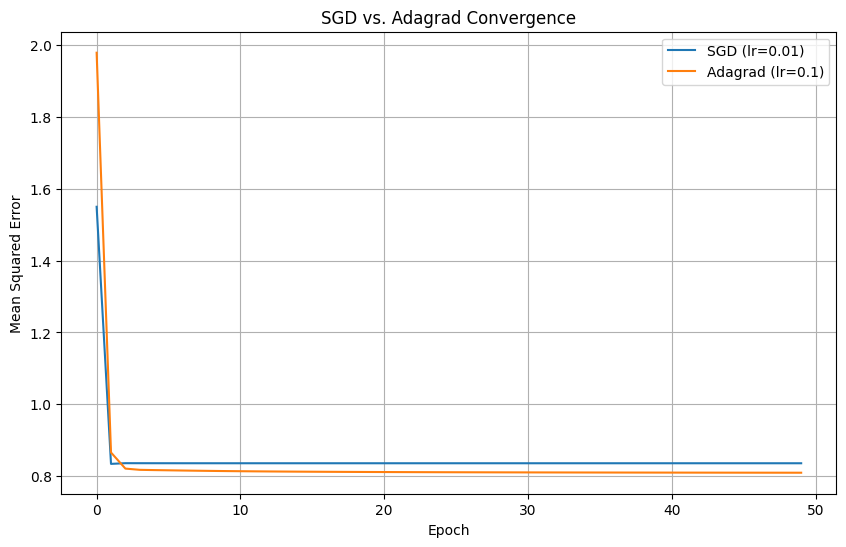

In [5]:
X = 2 * np.random.rand(100, 1)
y = 1 + 2*X + np.random.randn(100, 1)

def train(optimizer, epochs=50):
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(len(X)):
            x_sample, y_sample = X[i:i+1], y[i:i+1]
            w, b = optimizer.params
            y_pred = linear_model(x_sample, w, b)
            epoch_loss += mse_loss(y_sample, y_pred)
            optimizer.zero_grad()
            compute_gradients(x_sample, y_sample, y_pred, w, b)
            optimizer.step()
        loss_history.append(epoch_loss / len(X))

    current_lr = getattr(optimizer, 'lr', 'N/A')
    print(f"Optimizer: {optimizer.__class__.__name__} (lr={optimizer.lr})")
    w, b = optimizer.params
    print(f"Final Weights: w={w.data.item():.2f}, b={b.data.item():.2f}")
    return loss_history

np.random.seed(42)
w_sgd = Parameter(np.random.randn(1, 1))
b_sgd = Parameter(np.zeros(1))
sgd_optimizer = SGD(params=[w_sgd, b_sgd], lr=0.01)
sgd_losses = train(sgd_optimizer)

np.random.seed(42)
w_adagrad = Parameter(np.random.randn(1, 1))
b_adagrad = Parameter(np.zeros(1))

adagrad_optimizer = Adagrad(params=[w_adagrad, b_adagrad], lr=0.1)
adagrad_losses = train(adagrad_optimizer)

plt.figure(figsize=(10, 6))
plt.plot(sgd_losses, label='SGD (lr=0.01)')
plt.plot(adagrad_losses, label='Adagrad (lr=0.1)')
plt.title('SGD vs. Adagrad Convergence')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()